# Model Training
## Group SHINOBI: HONG-KOH-NOUV

This python notebook contents the results of training the model in different ways before submitting to ramp.

In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Model Building
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibratedClassifierCV

# Evaluation
from sklearn.metrics import balanced_accuracy_score
from problem import BalancedAccuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Data Preprocessing

- The EDA revealed large variability in total gene expression across cells, indicating differences in sequencing depth; therefore, normalization is applied to make cells comparable.
- Gene expression distributions were highly right-skewed with extreme values, motivating the use of a log transformation to stabilize variance and reduce the influence of outliers.
- Gene variance analysis showed that only a small subset of genes captures most of the variability in the data, justifying the selection of highly variable genes to reduce noise and dimensionality.
- Restricting the feature space to the most variable genes retains informative biological signals while discarding genes with little discriminative power.
- The presence of correlated genes and high-dimensional feature space motivates feature standardization to ensure comparable scaling before downstream analyses.
- The rapid accumulation of explained variance in the first principal components and strong gene redundancy justify the use of PCA to reduce dimensionality while preserving the main structure of the data.

### Preprocessing Pipeline

Preprocessing pipelines are evaluated progressively, starting from raw data and gradually incorporating normalization, variance stabilization, feature selection, scaling, and dimensionality reduction to assess their impact on model performance.

- Pipeline 1: Raw baseline
    - No preprocessing.
    - Used as a reference to measure the benefit of all transformations.

- Pipeline 2: Normalization only
    - Cells are normalized by their total expression to correct for sequencing depth differences.

- Pipeline 3: Normalization + log transform
    - Log transformation is added to reduce skewness and stabilize variance after normalization.

- Pipeline 4: Normalization + log transform + HVG selection
    - Feature space is reduced by keeping only highly variable genes, removing uninformative genes.

- Pipeline 5: Normalization + log transform + HVG selection + scaling
    - Features are standardized to ensure comparable scales, which is important for linear models and PCA.

- Pipeline 6: Normalization + log transform + HVG selection + scaling + PCA
    - Dimensionality is further reduced using PCA to remove redundancy and retain the main sources of variation.

In [4]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [26]:
def preprocess_normalize_sum(X_sparse):
    X = X_sparse.toarray().astype(np.float32)
    row_sum = X.sum(axis=1, keepdims=True)
    row_sum[row_sum == 0] = 1.0
    return X / row_sum

def preprocess_log1p(X):
    return np.log1p(X)

def fit_hvg_variance(X, top_k=2000):
    gene_var = X.var(axis=0)
    idx = np.argsort(gene_var)[-top_k:]
    return idx

def transform_gene_filter(X, gene_idx):
    return X[:, gene_idx]

def fit_standard_scaler(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    std[std == 0] = 1.0
    return mean, std

def transform_standard_scaler(X, mean, std):
    return (X - mean) / std

def fit_pca(X, n_components=50):
    pca = PCA(n_components=n_components, random_state=0)
    pca.fit(X)
    return pca

def transform_pca(X, pca):
    return pca.transform(X)

## Modeling

### Logistic Regression

Pipeline 0 (RAW) - Train balanced accuracy: 1.0
Pipeline 0 (RAW) - Test  balanced accuracy: 0.7766


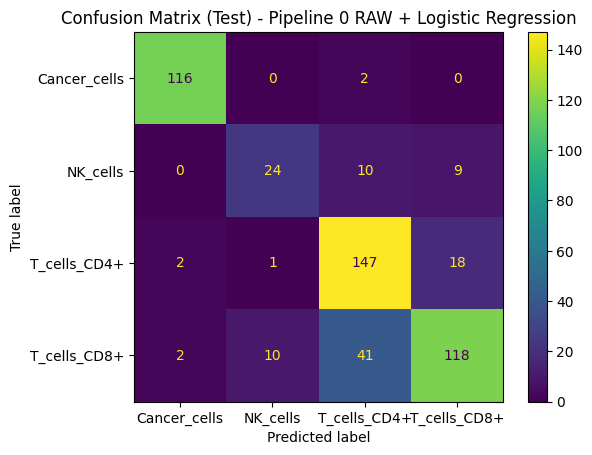

In [34]:
# =========================
# PIPELINE 0: RAW FEATURES
# =========================
X_train_0 = X_train.toarray().astype(np.float32)
X_test_0  = X_test.toarray().astype(np.float32)

pipe_0_logr = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty=None,
                max_iter=2000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

# Fit
pipe_0_logr.fit(X_train_0, y_train)

# Predict
y_train_pred_0 = pipe_0_logr.predict(X_train_0)
y_test_pred_0  = pipe_0_logr.predict(X_test_0)

# Score (balanced accuracy)
print("Pipeline 0 (RAW) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_0), 4))
print("Pipeline 0 (RAW) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_0), 4))

# Confusion matrix (test)
cm_0 = confusion_matrix(y_test, y_test_pred_0, labels=pipe_0_logr.classes_)
disp_0 = ConfusionMatrixDisplay(confusion_matrix=cm_0, display_labels=pipe_0_logr.classes_)
disp_0.plot()
plt.title("Confusion Matrix (Test) - Pipeline 0 RAW + Logistic Regression")
plt.show()


Train balanced accuracy: 1.0
Test  balanced accuracy: 0.7977


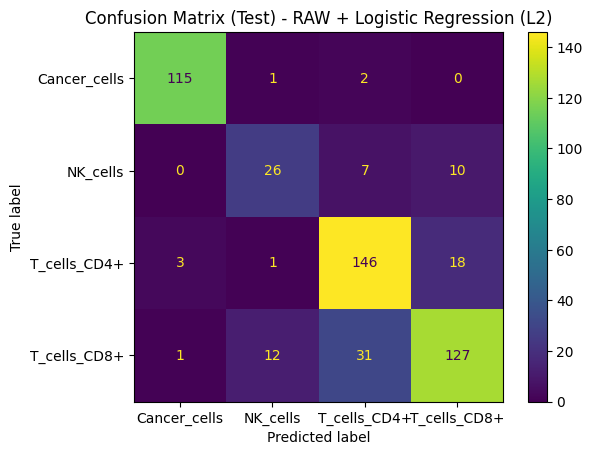

In [16]:
pipe_0_logr_p = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty="l2",
                C=0.05,
                max_iter=2000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_0_logr_p.fit(X_train_0, y_train)

y_train_pred_0 = pipe_0_logr_p.predict(X_train_0)
y_test_pred_0  = pipe_0_logr_p.predict(X_test_0)

print("Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_0), 4))
print("Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_0), 4))

cm_0 = confusion_matrix(y_test, y_test_pred_0, labels=pipe_0_logr_p.classes_)
disp_0 = ConfusionMatrixDisplay(confusion_matrix=cm_0, display_labels=pipe_0_logr_p.classes_)
disp_0.plot()
plt.title("Confusion Matrix (Test) - RAW + Logistic Regression (L2)")
plt.show()

Pipeline 1 (NORM) - Train balanced accuracy: 0.9768
Pipeline 1 (NORM) - Test  balanced accuracy: 0.7926


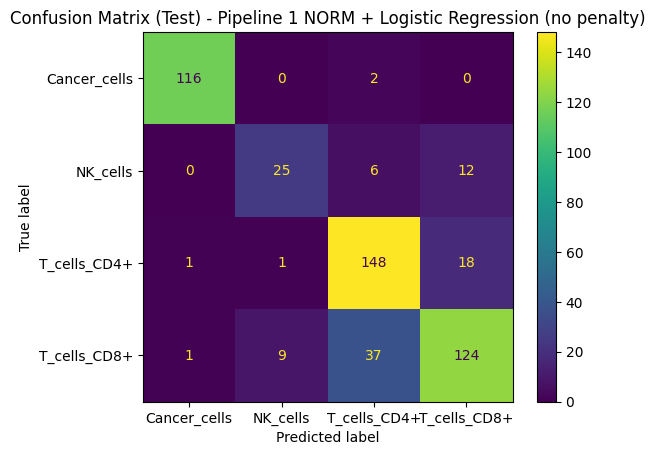

In [37]:
# =========================
# PIPELINE 1: NORMALIZED FEATURES (row-sum normalization)
# =========================

# Preprocess: normalize each row by its sum
X_train_1 = preprocess_normalize_sum(X_train)   # uses your function
X_test_1  = preprocess_normalize_sum(X_test)

# -------------------------
# Logistic Regression (no penalty)
# -------------------------
pipe_1_logr = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty=None,
                max_iter=2000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_1_logr.fit(X_train_1, y_train)

y_train_pred_1 = pipe_1_logr.predict(X_train_1)
y_test_pred_1  = pipe_1_logr.predict(X_test_1)

print("Pipeline 1 (NORM) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_1), 4))
print("Pipeline 1 (NORM) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_1), 4))

cm_1 = confusion_matrix(y_test, y_test_pred_1, labels=pipe_1_logr.classes_)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=pipe_1_logr.classes_)
disp_1.plot()
plt.title("Confusion Matrix (Test) - Pipeline 1 NORM + Logistic Regression (no penalty)")
plt.show()

Train balanced accuracy: 0.6967
Test  balanced accuracy: 0.6654


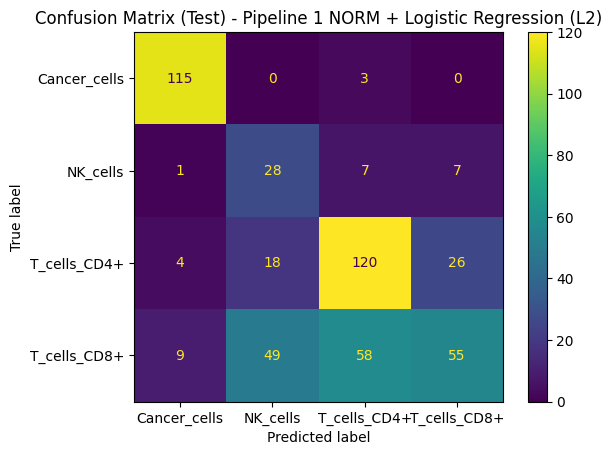

In [25]:
# -------------------------
# Logistic Regression (L2 penalty)
# -------------------------
pipe_1_logr_p = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty="l2",
                C=10,
                max_iter=1000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_1_logr_p.fit(X_train_1, y_train)

y_train_pred_1 = pipe_1_logr_p.predict(X_train_1)
y_test_pred_1  = pipe_1_logr_p.predict(X_test_1)

print("Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_1), 4))
print("Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_1), 4))

cm_1 = confusion_matrix(y_test, y_test_pred_1, labels=pipe_1_logr_p.classes_)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=pipe_1_logr_p.classes_)
disp_1.plot()
plt.title("Confusion Matrix (Test) - Pipeline 1 NORM + Logistic Regression (L2)")
plt.show()


Pipeline 2 (NORM+LOG) - Train balanced accuracy: 1.0
Pipeline 2 (NORM+LOG) - Test  balanced accuracy: 0.7919


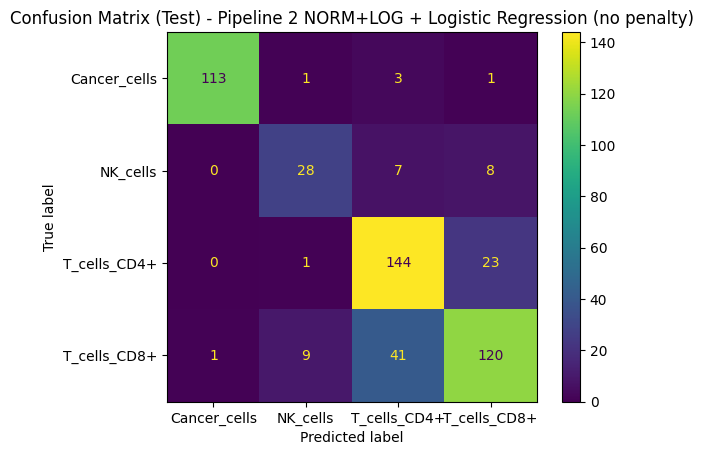

In [27]:
# =========================
# PIPELINE 2: NORMALIZE + LOG1P FEATURES
# =========================

# Preprocess: normalize each row by its sum + log1p
X_train_2 = preprocess_log1p(preprocess_normalize_sum(X_train))  # uses your functions
X_test_2  = preprocess_log1p(preprocess_normalize_sum(X_test))

# -------------------------
# Logistic Regression (no penalty)
# -------------------------
pipe_2_logr = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty=None,
                max_iter=2000,
                random_state=42,
            ),
        ),
    ]
)

pipe_2_logr.fit(X_train_2, y_train)

y_train_pred_2 = pipe_2_logr.predict(X_train_2)
y_test_pred_2  = pipe_2_logr.predict(X_test_2)

print("Pipeline 2 (NORM+LOG) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_2), 4))
print("Pipeline 2 (NORM+LOG) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_2), 4))

cm_2 = confusion_matrix(y_test, y_test_pred_2, labels=pipe_2_logr.classes_)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=pipe_2_logr.classes_)
disp_2.plot()
plt.title("Confusion Matrix (Test) - Pipeline 2 NORM+LOG + Logistic Regression (no penalty)")
plt.show()



Train balanced accuracy: 0.5694
Test  balanced accuracy: 0.558


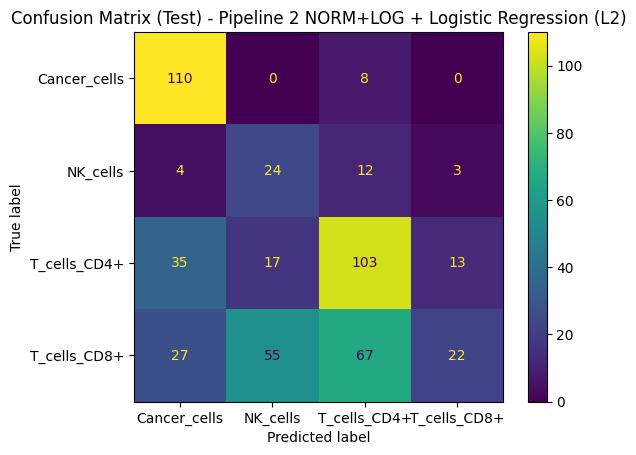

In [28]:

# -------------------------
# Logistic Regression (L2 penalty)
# -------------------------
pipe_2_logr_p = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty="l2",
                C=0.05,
                max_iter=2000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_2_logr_p.fit(X_train_2, y_train)

y_train_pred_2 = pipe_2_logr_p.predict(X_train_2)
y_test_pred_2  = pipe_2_logr_p.predict(X_test_2)

print("Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_2), 4))
print("Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_2), 4))

cm_2 = confusion_matrix(y_test, y_test_pred_2, labels=pipe_2_logr_p.classes_)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=pipe_2_logr_p.classes_)
disp_2.plot()
plt.title("Confusion Matrix (Test) - Pipeline 2 NORM+LOG + Logistic Regression (L2)")
plt.show()


Pipeline 3 (NORM+LOG+HVG) - Train balanced accuracy: 0.9798
Pipeline 3 (NORM+LOG+HVG) - Test  balanced accuracy: 0.7722


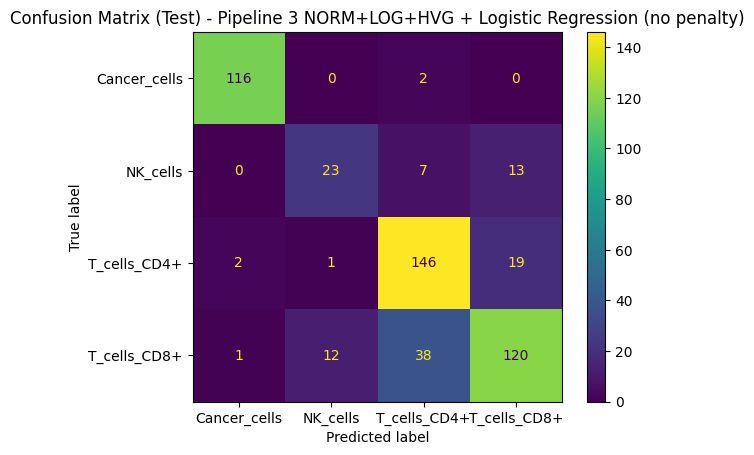

In [31]:
# -------------------------------------------------
# Step 1: base preprocessing (normalize + log1p)
# -------------------------------------------------
X_train_base = preprocess_log1p(preprocess_normalize_sum(X_train))
X_test_base  = preprocess_log1p(preprocess_normalize_sum(X_test))

# -------------------------------------------------
# Step 2: fit HVG on TRAIN ONLY (avoid leakage)
# -------------------------------------------------
top_k = 2000
gene_idx = fit_hvg_variance(X_train_base, top_k=top_k)

# Transform train/test using the same HVG index
X_train_3 = transform_gene_filter(X_train_base, gene_idx)
X_test_3  = transform_gene_filter(X_test_base, gene_idx)

# -------------------------
# Logistic Regression (no penalty)
# -------------------------
pipe_3_logr = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty=None,
                max_iter=2000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_3_logr.fit(X_train_3, y_train)

y_train_pred_3 = pipe_3_logr.predict(X_train_3)
y_test_pred_3  = pipe_3_logr.predict(X_test_3)

print("Pipeline 3 (NORM+LOG+HVG) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_3), 4))
print("Pipeline 3 (NORM+LOG+HVG) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_3), 4))

cm_3 = confusion_matrix(y_test, y_test_pred_3, labels=pipe_3_logr.classes_)
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=pipe_3_logr.classes_)
disp_3.plot()
plt.title("Confusion Matrix (Test) - Pipeline 3 NORM+LOG+HVG + Logistic Regression (no penalty)")
plt.show()



Train balanced accuracy: 0.5676
Test  balanced accuracy: 0.5566


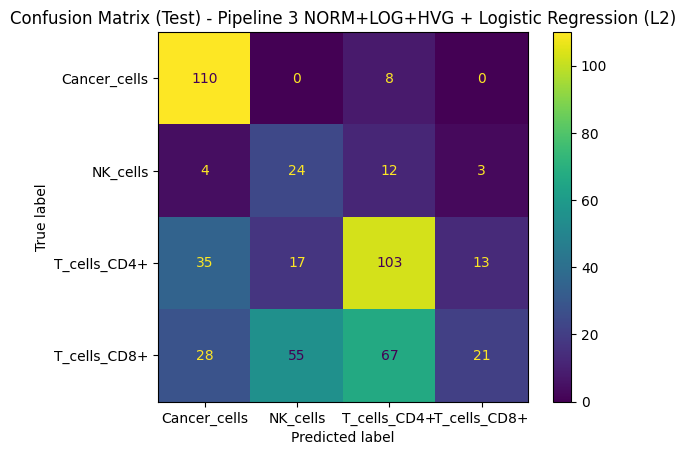

In [41]:

# -------------------------
# Logistic Regression (L2 penalty)
# -------------------------
pipe_3_logr_p = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty="l2",
                C=0.05,
                max_iter=2000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_3_logr_p.fit(X_train_3, y_train)

y_train_pred_3 = pipe_3_logr_p.predict(X_train_3)
y_test_pred_3  = pipe_3_logr_p.predict(X_test_3)

print("Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_3), 4))
print("Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_3), 4))

cm_3 = confusion_matrix(y_test, y_test_pred_3, labels=pipe_3_logr_p.classes_)
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=pipe_3_logr_p.classes_)
disp_3.plot()
plt.title("Confusion Matrix (Test) - Pipeline 3 NORM+LOG+HVG + Logistic Regression (L2)")
plt.show()

Pipeline 4 (NORM+LOG+HVG+SCALE) - Train balanced accuracy: 1.0
Pipeline 4 (NORM+LOG+HVG+SCALE) - Test  balanced accuracy: 0.8491


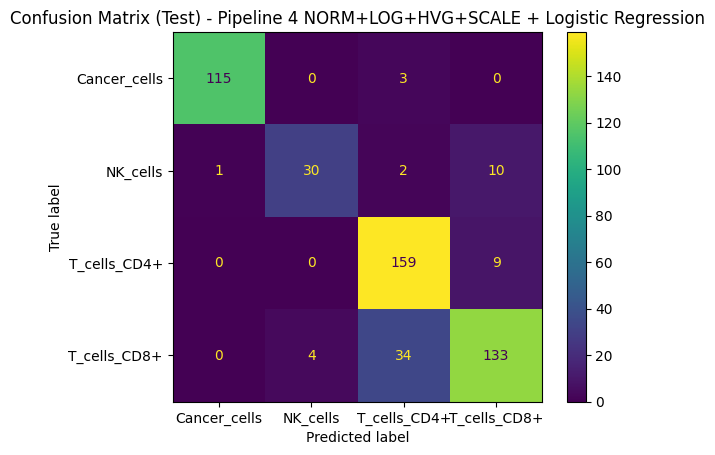

In [51]:
# =========================
# PIPELINE 4: NORMALIZE + LOG1P + HVG + SCALING
# Logistic Regression (no penalty)
# =========================

# -------------------------------------------------
# Step 1: normalize + log1p
# -------------------------------------------------
X_train_base = preprocess_log1p(preprocess_normalize_sum(X_train))
X_test_base  = preprocess_log1p(preprocess_normalize_sum(X_test))

# -------------------------------------------------
# Step 2: HVG fit on TRAIN ONLY
# -------------------------------------------------
top_k = 3000
gene_idx = fit_hvg_variance(X_train_base, top_k=top_k)

X_train_hvg = transform_gene_filter(X_train_base, gene_idx)
X_test_hvg  = transform_gene_filter(X_test_base, gene_idx)

# -------------------------------------------------
# Step 3: scaling fit on TRAIN ONLY
# -------------------------------------------------
mean, std = fit_standard_scaler(X_train_hvg)
X_train_4 = transform_standard_scaler(X_train_hvg, mean, std)
X_test_4  = transform_standard_scaler(X_test_hvg, mean, std)

# -------------------------------------------------
# Model: Logistic Regression (no penalty)
# -------------------------------------------------
pipe_4_logr = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty=None,
                max_iter=2000,
                random_state=42,
            ),
        ),
    ]
)

pipe_4_logr.fit(X_train_4, y_train)

y_train_pred_4 = pipe_4_logr.predict(X_train_4)
y_test_pred_4  = pipe_4_logr.predict(X_test_4)

print("Pipeline 4 (NORM+LOG+HVG+SCALE) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_4), 4))
print("Pipeline 4 (NORM+LOG+HVG+SCALE) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_4), 4))

cm_4 = confusion_matrix(y_test, y_test_pred_4, labels=pipe_4_logr.classes_)
disp_4 = ConfusionMatrixDisplay(confusion_matrix=cm_4, display_labels=pipe_4_logr.classes_)
disp_4.plot()
plt.title("Confusion Matrix (Test) - Pipeline 4 NORM+LOG+HVG+SCALE + Logistic Regression")
plt.show()


Pipeline 4 (NORM+LOG+HVG+SCALE) - Train balanced accuracy: 1.0
Pipeline 4 (NORM+LOG+HVG+SCALE) - Test  balanced accuracy: 0.8171


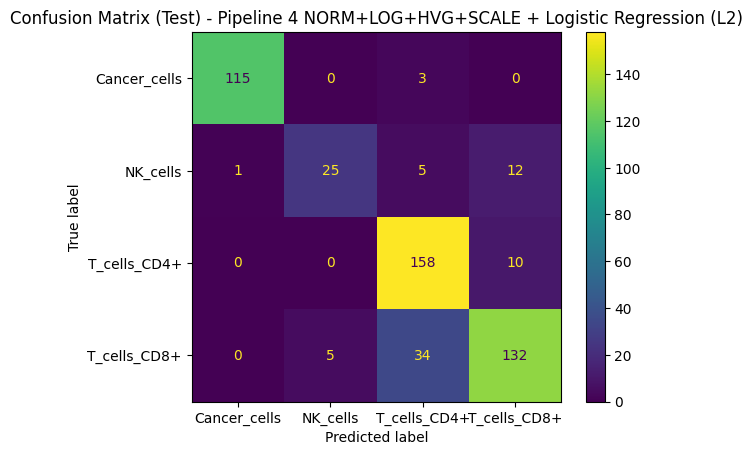

In [62]:
# -------------------------------------------------
# Model: Logistic Regression (L2 penalty)
# -------------------------------------------------
pipe_4_logr_l2 = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty="l2",
                C=0.05,
                max_iter=2000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_4_logr_l2.fit(X_train_4, y_train)

y_train_pred_4 = pipe_4_logr_l2.predict(X_train_4)
y_test_pred_4  = pipe_4_logr_l2.predict(X_test_4)

print("Pipeline 4 (NORM+LOG+HVG+SCALE) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_4), 4))
print("Pipeline 4 (NORM+LOG+HVG+SCALE) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_4), 4))

cm_4 = confusion_matrix(y_test, y_test_pred_4, labels=pipe_4_logr_l2.classes_)
disp_4 = ConfusionMatrixDisplay(confusion_matrix=cm_4, display_labels=pipe_4_logr_l2.classes_)
disp_4.plot()
plt.title("Confusion Matrix (Test) - Pipeline 4 NORM+LOG+HVG+SCALE + Logistic Regression (L2)")
plt.show()


Pipeline 5 (NORM+LOG+HVG+SCALE+PCA) - Train balanced accuracy: 1.0
Pipeline 5 (NORM+LOG+HVG+SCALE+PCA) - Test  balanced accuracy: 0.8338


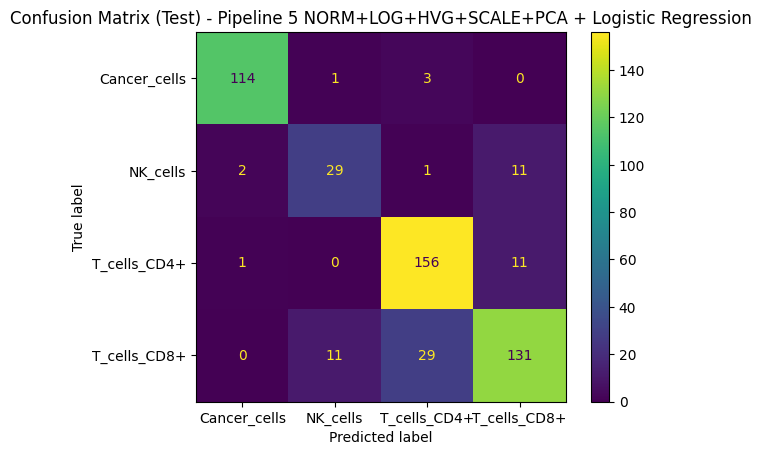

In [58]:
# =========================
# PIPELINE 5: NORMALIZE + LOG1P + HVG + SCALING + PCA
# Logistic Regression (no penalty)
# =========================

# -------------------------------------------------
# Step 1: normalize + log1p
# -------------------------------------------------
X_train_base = preprocess_log1p(preprocess_normalize_sum(X_train))
X_test_base  = preprocess_log1p(preprocess_normalize_sum(X_test))

# -------------------------------------------------
# Step 2: HVG fit on TRAIN ONLY
# -------------------------------------------------
top_k = 3000
gene_idx = fit_hvg_variance(X_train_base, top_k=top_k)

X_train_hvg = transform_gene_filter(X_train_base, gene_idx)
X_test_hvg  = transform_gene_filter(X_test_base, gene_idx)

# -------------------------------------------------
# Step 3: scaling fit on TRAIN ONLY
# -------------------------------------------------
mean, std = fit_standard_scaler(X_train_hvg)
X_train_scaled = transform_standard_scaler(X_train_hvg, mean, std)
X_test_scaled  = transform_standard_scaler(X_test_hvg, mean, std)

# -------------------------------------------------
# Step 4: PCA fit on TRAIN ONLY
# -------------------------------------------------
n_components = 500
pca = fit_pca(X_train_scaled, n_components=n_components)

X_train_5 = transform_pca(X_train_scaled, pca)
X_test_5  = transform_pca(X_test_scaled, pca)

# -------------------------------------------------
# Model: Logistic Regression (no penalty)
# -------------------------------------------------
pipe_5_logr = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty=None,
                max_iter=2000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_5_logr.fit(X_train_5, y_train)

y_train_pred_5 = pipe_5_logr.predict(X_train_5)
y_test_pred_5  = pipe_5_logr.predict(X_test_5)

print("Pipeline 5 (NORM+LOG+HVG+SCALE+PCA) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_5), 4))
print("Pipeline 5 (NORM+LOG+HVG+SCALE+PCA) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_5), 4))

cm_5 = confusion_matrix(y_test, y_test_pred_5, labels=pipe_5_logr.classes_)
disp_5 = ConfusionMatrixDisplay(confusion_matrix=cm_5, display_labels=pipe_5_logr.classes_)
disp_5.plot()
plt.title("Confusion Matrix (Test) - Pipeline 5 NORM+LOG+HVG+SCALE+PCA + Logistic Regression")
plt.show()


### Linear SVM

Linear SVM - P0 RAW - Train balanced accuracy: 1.0
Linear SVM - P0 RAW - Test  balanced accuracy: 0.744


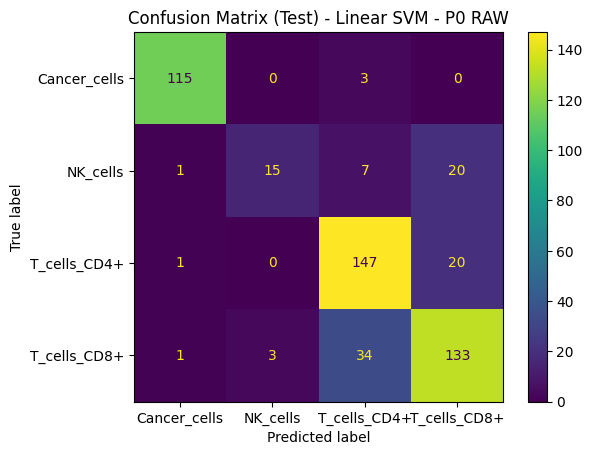

In [79]:
# LinearSVC does NOT have predict_proba, so we calibrate it to get probabilities
svm_0 = LinearSVC(
    C=0.1,
    class_weight="balanced",
    random_state=42,
    max_iter=10000,
)

pipe_0_svm = Pipeline(
    [
        ("LinearSVC", CalibratedClassifierCV(svm_0, method="sigmoid", cv=5)),
    ]
)

pipe_0_svm.fit(X_train_0, y_train)

y_train_pred_0 = pipe_0_svm.predict(X_train_0)
y_test_pred_0  = pipe_0_svm.predict(X_test_0)

print("Linear SVM - P0 RAW - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_0), 4))
print("Linear SVM - P0 RAW - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_0), 4))

cm_0 = confusion_matrix(y_test, y_test_pred_0, labels=pipe_0_svm.classes_)
disp_0 = ConfusionMatrixDisplay(confusion_matrix=cm_0, display_labels=pipe_0_svm.classes_)
disp_0.plot()
plt.title("Confusion Matrix (Test) - Linear SVM - P0 RAW")
plt.show()

Linear SVM - P4 - Train balanced accuracy: 0.9353
Linear SVM - P4 - Test  balanced accuracy: 0.6877


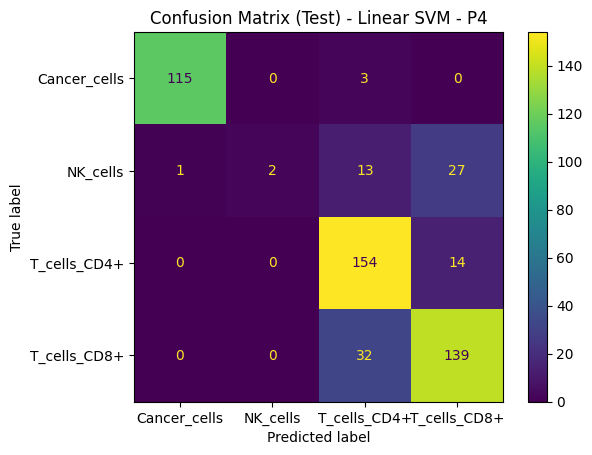

In [75]:
# Calibrated Linear SVM
svm_4 = LinearSVC(
    C=1.0,
    class_weight="balanced",
    random_state=42,
    max_iter=5000,
)

pipe_4_svm = Pipeline(
    [
        ("LinearSVC", CalibratedClassifierCV(svm_4, method="sigmoid", cv=5)),
    ]
)

pipe_4_svm.fit(X_train_4, y_train)

y_train_pred_4 = pipe_4_svm.predict(X_train_4)
y_test_pred_4  = pipe_4_svm.predict(X_test_4)

print("Linear SVM - P4 - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_4), 4))
print("Linear SVM - P4 - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_4), 4))

cm_4 = confusion_matrix(y_test, y_test_pred_4, labels=pipe_4_svm.classes_)
disp_4 = ConfusionMatrixDisplay(confusion_matrix=cm_4, display_labels=pipe_4_svm.classes_)
disp_4.plot()
plt.title("Confusion Matrix (Test) - Linear SVM - P4")
plt.show()

P3 SVM - Train balanced accuracy: 0.6128
P3 SVM - Test  balanced accuracy: 0.5923


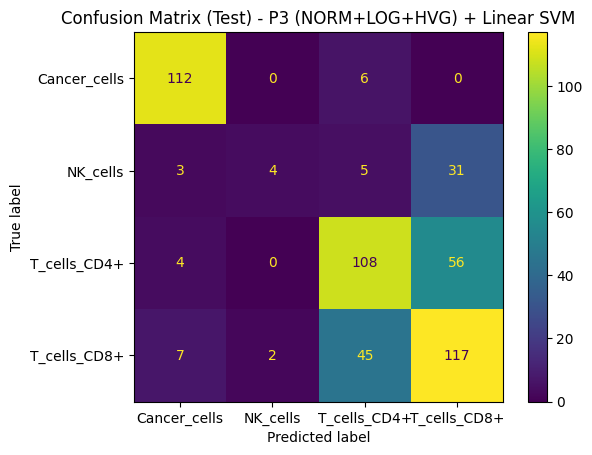

In [77]:
# -------------------------------------------------
# Model: Linear SVM (Calibrated for predict_proba)
# -------------------------------------------------
svm = LinearSVC(
    C=1.0,
    class_weight="balanced",
    random_state=42,
    max_iter=5000,
)

pipe_3_svm = Pipeline(
    [
        ("CalibratedLinearSVC", CalibratedClassifierCV(svm, method="sigmoid", cv=5)),
    ]
)

pipe_3_svm.fit(X_train_3, y_train)

y_train_pred_3 = pipe_3_svm.predict(X_train_3)
y_test_pred_3  = pipe_3_svm.predict(X_test_3)

print("P3 SVM - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_3), 4))
print("P3 SVM - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_3), 4))

cm_3 = confusion_matrix(y_test, y_test_pred_3, labels=pipe_3_svm.classes_)
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=pipe_3_svm.classes_)
disp_3.plot()
plt.title("Confusion Matrix (Test) - P3 (NORM+LOG+HVG) + Linear SVM")
plt.show()

### Gaussian Navies Bayes

Naive Bayes (P1) - Train balanced accuracy: 0.9927
Naive Bayes (P1) - Test  balanced accuracy: 0.5526


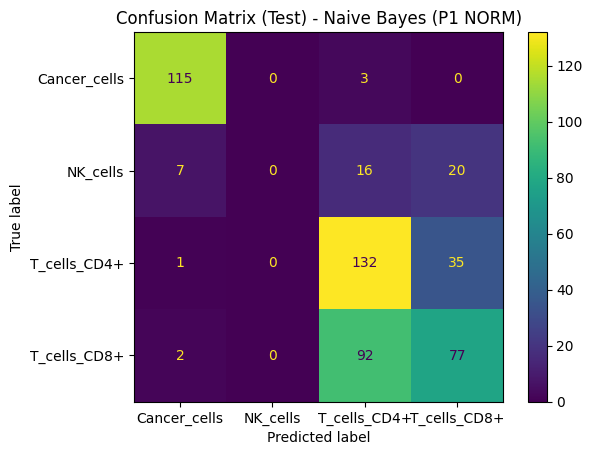

In [112]:
pipe_nb_p1 = Pipeline(
    [
        ("GaussianNB", GaussianNB(var_smoothing=1e-8)),
    ]
)

pipe_nb_p1.fit(X_train_1, y_train)

y_train_pred = pipe_nb_p1.predict(X_train_1)
y_test_pred  = pipe_nb_p1.predict(X_test_1)

print("Naive Bayes (P1) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Naive Bayes (P1) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_nb_p1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_nb_p1.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Naive Bayes (P1 NORM)")
plt.show()

Naive Bayes (P2) - Train balanced accuracy: 0.9927
Naive Bayes (P2) - Test  balanced accuracy: 0.5483


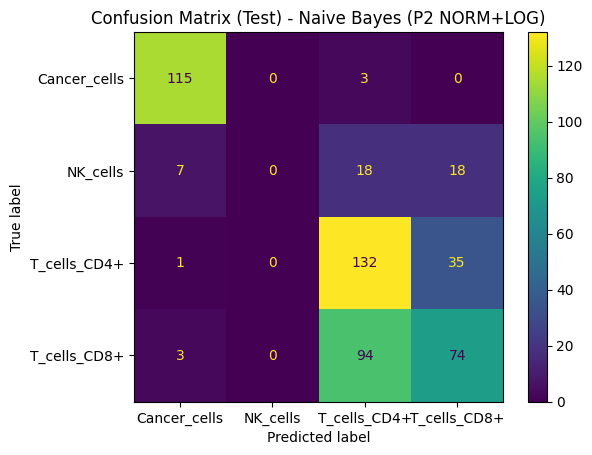

In [96]:
# =========================
# NAIVE BAYES - PIPELINE 2 (NORM + LOG1P)
# =========================

pipe_nb_p2 = Pipeline(
    [
        ("GaussianNB", GaussianNB(var_smoothing=1e-8)),
    ]
)

pipe_nb_p2.fit(X_train_2, y_train)

y_train_pred = pipe_nb_p2.predict(X_train_2)
y_test_pred  = pipe_nb_p2.predict(X_test_2)

print("Naive Bayes (P2) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Naive Bayes (P2) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_nb_p2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_nb_p2.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Naive Bayes (P2 NORM+LOG)")
plt.show()


Naive Bayes (P3) - Train balanced accuracy: 0.848
Naive Bayes (P3) - Test  balanced accuracy: 0.6627


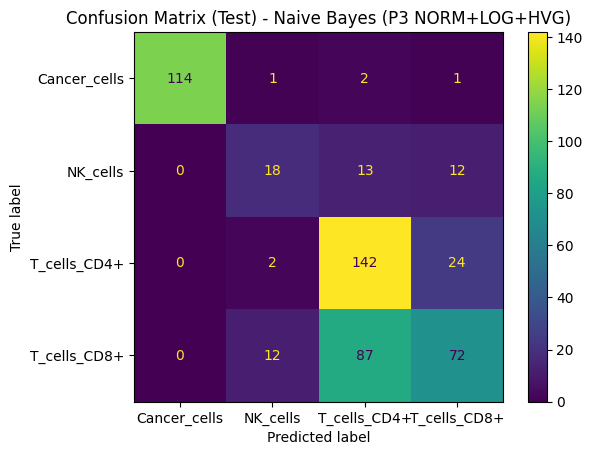

In [107]:
pipe_nb_p3 = Pipeline(
    [
        ("GaussianNB", GaussianNB(var_smoothing=1e-7)),
    ]
)

pipe_nb_p3.fit(X_train_3, y_train)

y_train_pred = pipe_nb_p3.predict(X_train_3)
y_test_pred  = pipe_nb_p3.predict(X_test_3)

print("Naive Bayes (P3) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Naive Bayes (P3) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_nb_p3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_nb_p3.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Naive Bayes (P3 NORM+LOG+HVG)")
plt.show()

### Random Forest

Random Forest (P3) - Train balanced accuracy: 0.9778
Random Forest (P3) - Test  balanced accuracy: 0.8321


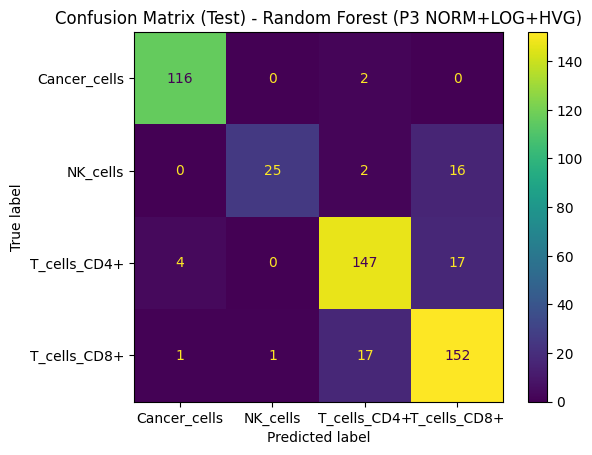

In [121]:
# -------------------------------------------------
# Model: Random Forest
# -------------------------------------------------
pipe_rf_p3 = Pipeline(
    [
        ("RandomForest", RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            max_features="sqrt",
            min_samples_leaf=7,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

pipe_rf_p3.fit(X_train_3, y_train)

y_train_pred = pipe_rf_p3.predict(X_train_3)
y_test_pred  = pipe_rf_p3.predict(X_test_3)

print("Random Forest (P3) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Random Forest (P3) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_rf_p3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_rf_p3.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Random Forest (P3 NORM+LOG+HVG)")
plt.show()

In [120]:
n_estimators_list = [50, 100, 150]
max_depth_list = [None]
max_features_list = ["sqrt", "log2"]
min_samples_leaf_list = [5, 7, 9]

best = None

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for max_features in max_features_list:
            for min_samples_leaf in min_samples_leaf_list:
                rf = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    max_features=max_features,
                    min_samples_leaf=min_samples_leaf,
                    class_weight="balanced",
                    random_state=42,
                    n_jobs=-1,
                )

                rf.fit(X_train_3, y_train)
                y_pred = rf.predict(X_test_3)
                score = balanced_accuracy_score(y_test, y_pred)

                print(
                    f"n={n_estimators}, depth={max_depth}, feat={max_features}, leaf={min_samples_leaf} "
                    f"-> test bal acc = {score:.4f}"
                )

                if best is None or score > best["score"]:
                    best = {
                        "score": score,
                        "n_estimators": n_estimators,
                        "max_depth": max_depth,
                        "max_features": max_features,
                        "min_samples_leaf": min_samples_leaf,
                    }

print("\nBEST:")
print(best)

n=50, depth=None, feat=sqrt, leaf=5 -> test bal acc = 0.7942
n=50, depth=None, feat=sqrt, leaf=7 -> test bal acc = 0.8009
n=50, depth=None, feat=sqrt, leaf=9 -> test bal acc = 0.8160
n=50, depth=None, feat=log2, leaf=5 -> test bal acc = 0.7314
n=50, depth=None, feat=log2, leaf=7 -> test bal acc = 0.7678
n=50, depth=None, feat=log2, leaf=9 -> test bal acc = 0.7623
n=100, depth=None, feat=sqrt, leaf=5 -> test bal acc = 0.7978
n=100, depth=None, feat=sqrt, leaf=7 -> test bal acc = 0.8321
n=100, depth=None, feat=sqrt, leaf=9 -> test bal acc = 0.8233
n=100, depth=None, feat=log2, leaf=5 -> test bal acc = 0.7605
n=100, depth=None, feat=log2, leaf=7 -> test bal acc = 0.7458
n=100, depth=None, feat=log2, leaf=9 -> test bal acc = 0.7519
n=150, depth=None, feat=sqrt, leaf=5 -> test bal acc = 0.8102
n=150, depth=None, feat=sqrt, leaf=7 -> test bal acc = 0.8262
n=150, depth=None, feat=sqrt, leaf=9 -> test bal acc = 0.8247
n=150, depth=None, feat=log2, leaf=5 -> test bal acc = 0.7474
n=150, depth=N

Random Forest (P2) - Train balanced accuracy: 0.9838
Random Forest (P2) - Test  balanced accuracy: 0.7883


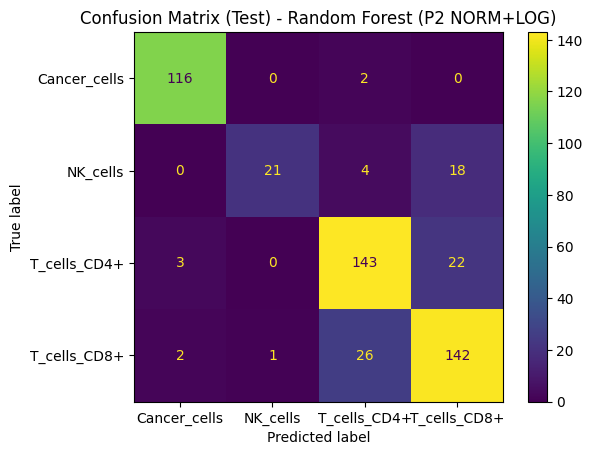

In [122]:
pipe_rf_p2 = Pipeline(
    [
        ("RandomForest", RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            max_features="sqrt",
            min_samples_leaf=7,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

pipe_rf_p2.fit(X_train_2, y_train)

y_train_pred = pipe_rf_p2.predict(X_train_2)
y_test_pred  = pipe_rf_p2.predict(X_test_2)

print("Random Forest (P2) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Random Forest (P2) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_rf_p2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_rf_p2.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Random Forest (P2 NORM+LOG)")
plt.show()

Random Forest (P4) - Train balanced accuracy: 0.9815
Random Forest (P4) - Test  balanced accuracy: 0.8058


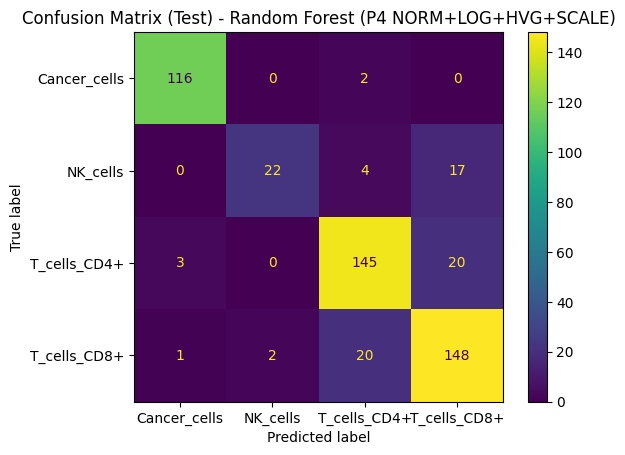

In [123]:
pipe_rf_p4 = Pipeline(
    [
        ("RandomForest", RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            max_features="sqrt",
            min_samples_leaf=7,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

pipe_rf_p4.fit(X_train_4, y_train)

y_train_pred = pipe_rf_p4.predict(X_train_4)
y_test_pred  = pipe_rf_p4.predict(X_test_4)

print("Random Forest (P4) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Random Forest (P4) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_rf_p4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_rf_p4.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Random Forest (P4 NORM+LOG+HVG+SCALE)")
plt.show()

Random Forest (P0) - Train balanced accuracy: 0.9638
Random Forest (P0) - Test  balanced accuracy: 0.7772


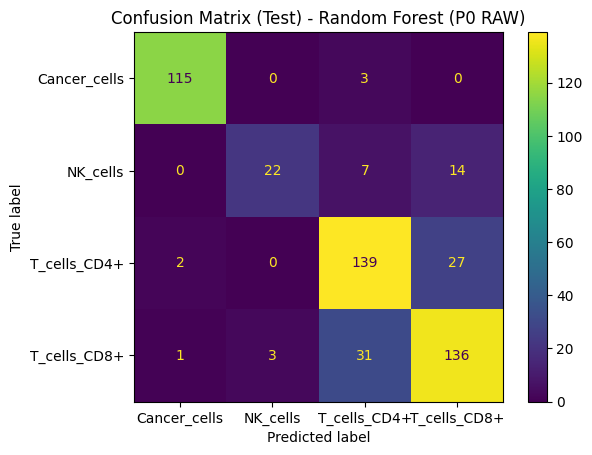

In [142]:
pipe_rf_p0 = Pipeline(
    [
        ("RandomForest", RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            max_features="sqrt",
            min_samples_leaf=7,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

pipe_rf_p0.fit(X_train_0, y_train)

y_train_pred = pipe_rf_p0.predict(X_train_0)
y_test_pred  = pipe_rf_p0.predict(X_test_0)

print("Random Forest (P0) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Random Forest (P0) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_rf_p0.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_rf_p0.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Random Forest (P0 RAW)")
plt.show()

Random Forest (P5) - Train balanced accuracy: 0.9713
Random Forest (P5) - Test  balanced accuracy: 0.7642


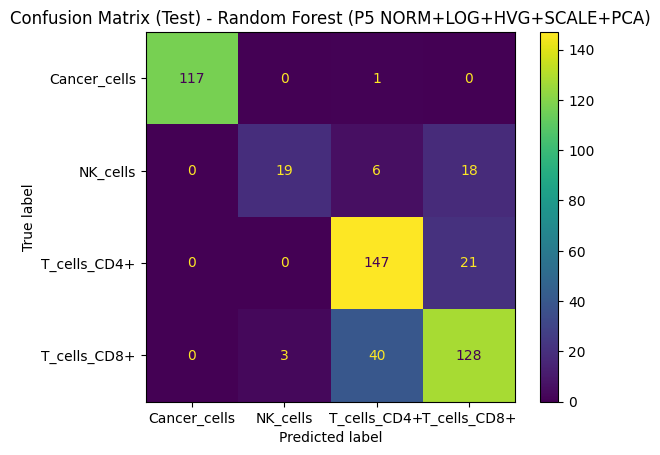

In [136]:
# =========================
# RANDOM FOREST - PIPELINE 5 (NORM + LOG1P + HVG + SCALE + PCA)
# =========================
# -------------------------------------------------
# Model: Random Forest
# -------------------------------------------------
pipe_rf_p5 = Pipeline(
    [
        ("RandomForest", RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            max_features="sqrt",
            min_samples_leaf=6,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

pipe_rf_p5.fit(X_train_5, y_train)

y_train_pred = pipe_rf_p5.predict(X_train_5)
y_test_pred  = pipe_rf_p5.predict(X_test_5)

print("Random Forest (P5) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Random Forest (P5) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_rf_p5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_rf_p5.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Random Forest (P5 NORM+LOG+HVG+SCALE+PCA)")
plt.show()
